In [1]:
# imports for the practice (you can add more if you need)
import os
import math
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib inline

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### <img src="https://img.icons8.com/color/48/000000/code.png" style="height:50px;display:inline"> Task 2 - FashionMNIST Deep Classifer
---
In this task we are going to design and train a neural network for classification.

In [9]:
def get_fashion_mnist_dataloaders(batch_size=128):
    """Fashion MNIST dataloader with (32, 32) sized images."""
    # Resize images
    all_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,),)
    ])
    # Get train and test data
    train_data = datasets.FashionMNIST('../fashion_data', train=True, download=True,
                                        transform=transforms.ToTensor())
    test_data = datasets.FashionMNIST('../fashion_data', train=False,
                                        transform=transforms.ToTensor())
    ## Preparing for validation set
    indices = list(range(len(train_data)))
    np.random.shuffle(indices)

    ## get 10% of the trainset for validation
    split = int(np.floor(0.1 * len(train_data)))
    valid_sample = SubsetRandomSampler(indices[:split])
    train_sample = SubsetRandomSampler(indices[split:])

    # Create dataloaders
    train_loader = DataLoader(train_data, sampler=train_sample, batch_size=batch_size)
    valid_loader = DataLoader(train_data, sampler=valid_sample, batch_size=batch_size)
    #train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


    # define classes
    classes =    ("T-shirt/Top",
                  "Trouser",
                  "Pullover",
                  "Dress",
                  "Coat", 
                  "Sandal", 
                  "Shirt",
                  "Sneaker",
                  "Bag",
                  "Ankle Boot")
    return train_loader, valid_loader, test_loader, classes

**section 1:**
Load the FashionMNIST dataset `torchvision.datasets.FashionMNIST` and display 6 images with their labels from the dataset.

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../fashion_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../fashion_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../fashion_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../fashion_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../fashion_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../fashion_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../fashion_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../fashion_data/FashionMNIST/raw



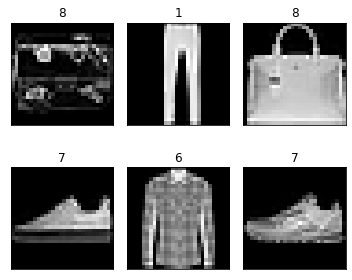

In [10]:
# Load FashionMNIST dataset
train_loader, valid_loader, test_loader, classes = get_fashion_mnist_dataloaders(batch_size=64)

# Display 6 images with their labels
data_iter = iter(train_loader)
images, labels = data_iter.next()

fig = plt.figure(figsize=(5,5))
for i in range(6):
    ax = fig.add_subplot(2, 3, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[i]), cmap='gray')
    ax.set_title(labels[i].item()) # .item() gets the value contained in a tensor
    fig.tight_layout()

**Section 2:**
Design a **MLP** to classify images from the FashionMNIST dataset.

In [11]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        # model definitions/blocks
        self.fc_layers = nn.Sequential(
            nn.Linear(784,784),
            nn.ReLU(),
            nn.BatchNorm1d(784),
            nn.Linear(784,256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64,10),
            )
        
        self.output_layer = nn.LogSoftmax(dim = 1)

    def forward(self, x):
        # flatten
        x = x.view(x.size(0), -1)
        
        return self.output_layer(self.fc_layers(x))

In [12]:
### Helper Functions ###
# function to calcualte accuracy of the model
def calculate_accuracy(model, dataloader, device, criterion):
    model.eval() # put in evaluation mode
    total_correct = 0
    total_images = 0
    running_loss = 0.0
    confusion_matrix = np.zeros([10,10], int)
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels) # calculate the loss
            running_loss += loss.data.item()
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            for i, l in enumerate(labels):
                confusion_matrix[l.item(), predicted[i].item()] += 1

    # Normalizing the loss by the total number of train batches
    running_loss /= len(dataloader)
    model_accuracy = total_correct / total_images * 100
    return model_accuracy, confusion_matrix, running_loss

# use a different initialization for the model
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        #nn.init.xavier_normal_(m.weight, gain=1.0)
        #nn.init.normal_(m.weight, 0, 0.005)
        nn.init.normal_(m.bias, 0, 0.005)
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        #nn.init.kaiming_normal_(m.bias, mode='fan_out', nonlinearity='relu')
        #nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu', a=math.sqrt(5))

In [13]:
def compile_model(model, init_weights=False):
    # hyper-parameters
    batch_size = 64
    learning_rate = 2e-4
    epochs = 25
    val_loss_stop = 0.2

    # Load FashionMNIST dataset
    train_loader, valid_loader, test_loader, classes = get_fashion_mnist_dataloaders(batch_size)

    # device - cpu or gpu?
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # loss criterion
    criterion = nn.CrossEntropyLoss()

    # build our model and send it to the device
    model = model().to(device)

    # optimizer - SGD, Adam, RMSProp...
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # weights initialization
    if (init_weights == True):
        model.apply(weights_init)

    # training loop
    train_losses = []
    valid_losses = []
    for epoch in range(1, epochs + 1):
        model.train() # put in training mode
        running_loss = 0.0
        total_correct = 0
        total_images = 0
        epoch_time = time.time()
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data
            # send them to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward + backward + optimize
            outputs = model(inputs) # forward pass
            loss = criterion(outputs, labels) # calculate the loss

            # always the same 3 steps
            optimizer.zero_grad() # zero the parameter gradients
            loss.backward() # backpropagation
            optimizer.step() # update parameters

            # calc accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()

            # print statistics
            running_loss += loss.data.item()

        # Normalizing the loss by the total number of train batches
        running_loss /= len(train_loader)
        train_losses.append(running_loss)

        # Calculate training/test set accuracy of the existing model
        train_accuracy = total_correct / total_images * 100
        valid_accuracy, _, valid_loss = calculate_accuracy(model, valid_loader, device, criterion)
        valid_losses.append(valid_loss)


        log = "Epoch: {} | Train Loss: {:.4f} | Training accuracy: {:.3f}% | Validation Loss: {:.3f} | Validation accuracy: {:.3f}% | ".format(epoch
        , running_loss, train_accuracy, valid_loss, valid_accuracy)
        epoch_time = time.time() - epoch_time
        log += "Epoch Time: {:.2f} secs".format(epoch_time)
        print(log)

        # early stopping
        if(valid_loss < val_loss_stop):
            print("early stopping")
            break

    print('==> Finished Training ...')
    
    # calculate accuracy and confusion matrix
    test_accuracy, confusion_matrix, _ = calculate_accuracy(model, test_loader, device, criterion)
    print("test accuracy: {:.3f}%".format(test_accuracy))

    # plot confusion matrix
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
    plt.ylabel('Actual Category')
    plt.yticks(range(10), classes)
    plt.xlabel('Predicted Category')
    plt.xticks(range(10), classes)
    plt.show()

    # print loss curves
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')

Epoch: 1 | Train Loss: 0.5214 | Training accuracy: 83.624% | Validation Loss: 0.404 | Validation accuracy: 85.717% | Epoch Time: 11.85 secs
Epoch: 2 | Train Loss: 0.3630 | Training accuracy: 86.950% | Validation Loss: 0.368 | Validation accuracy: 87.133% | Epoch Time: 11.80 secs
Epoch: 3 | Train Loss: 0.3246 | Training accuracy: 88.254% | Validation Loss: 0.390 | Validation accuracy: 85.550% | Epoch Time: 11.72 secs
Epoch: 4 | Train Loss: 0.3003 | Training accuracy: 88.900% | Validation Loss: 0.332 | Validation accuracy: 88.167% | Epoch Time: 11.58 secs
Epoch: 5 | Train Loss: 0.2845 | Training accuracy: 89.507% | Validation Loss: 0.348 | Validation accuracy: 87.183% | Epoch Time: 11.77 secs
Epoch: 6 | Train Loss: 0.2694 | Training accuracy: 90.026% | Validation Loss: 0.323 | Validation accuracy: 88.433% | Epoch Time: 11.59 secs
Epoch: 7 | Train Loss: 0.2583 | Training accuracy: 90.424% | Validation Loss: 0.347 | Validation accuracy: 87.733% | Epoch Time: 11.87 secs
Epoch: 8 | Train Los

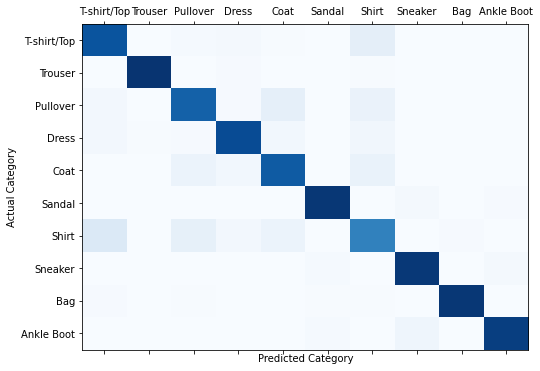

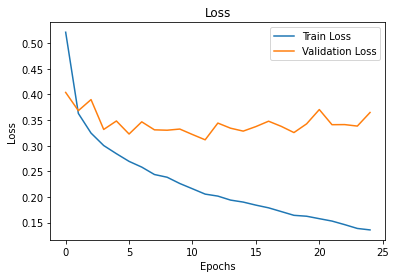

In [14]:
compile_model(model=MyModel, init_weights=False)

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
---
* Icons made by <a href="https://www.flaticon.com/authors/becris" title="Becris">Becris</a> from <a href="https://www.flaticon.com/" title="Flaticon">www.flaticon.com</a>
* Icons from <a href="https://icons8.com/">Icons8.com</a> - https://icons8.com
* Datasets from <a href="https://www.kaggle.com/">Kaggle</a> - https://www.kaggle.com/